In [4]:
import json
from typing import NamedTuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from scipy.fft import fft, fftfreq
import pandas as pd

In [29]:
SAMPLING_RATE = 64 #Hz
LOW_FREQ = 10 #Hz
HIGH_FREQ = 31 #Hz
BVP_PEAK_THRESHOLD = 15

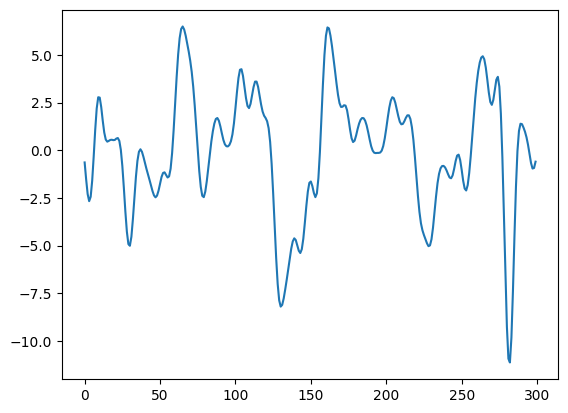

In [48]:
df = pd.read_csv('./../../recordings/empatica/gym_12kmh/BVP.csv', skiprows=2, header=None)
bvp = df[0].values
bvp = np.array(bvp)
bvp = bvp[4200:4500]
bvp[bvp > BVP_PEAK_THRESHOLD] = 0
bvp[bvp < - BVP_PEAK_THRESHOLD] = 0
plt.plot(bvp)

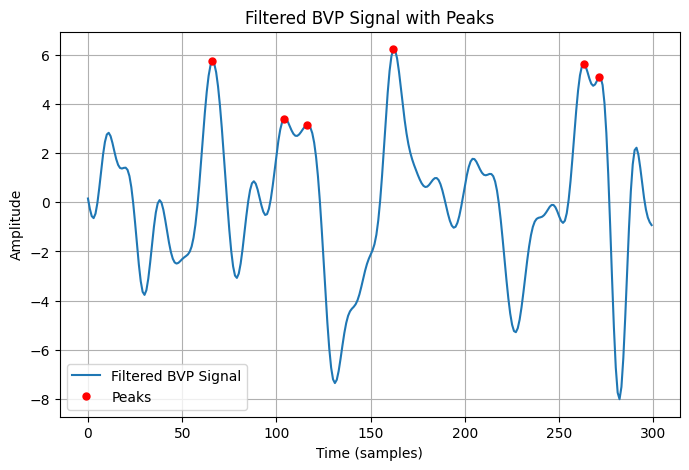

[101.05263158 320.          83.47826087  38.01980198 480.        ]


In [54]:
def bandpass_filter(signal_data, low_freq, high_freq, sampling_rate):
    nyquist_freq = 0.5 * sampling_rate
    low = low_freq / nyquist_freq
    high = high_freq / nyquist_freq
    order = 4  # Filter order
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal_data)
    return filtered_signal

# Define passband frequencies for BVP signal
low_freq = 0.5  # Lower passband frequency in Hz
high_freq = 5.0  # Upper passband frequency in Hz

filtered_bvp_signal = bandpass_filter(bvp, low_freq, high_freq, sampling_rate=SAMPLING_RATE)

peaks, _ = find_peaks(filtered_bvp_signal, height=3)

ibi_signal = np.diff(peaks) / SAMPLING_RATE
hr_signal = 60 / ibi_signal


plt.figure(figsize=(8, 5))
# plt.plot(bvp, label='BVP Signal')
plt.plot(filtered_bvp_signal, label='Filtered BVP Signal')
plt.plot(peaks, filtered_bvp_signal[peaks], 'r.', markersize=10, label='Peaks')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Filtered BVP Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()
print(hr_signal)

